# **<center>Machine Learning and Finance </center>**


## <center>Optional Reading - The Word2vec Approach - </center>

<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://hm-ai.github.io/MLF/">
    <img src="https://drive.google.com/uc?export=view&id=1gmxxmwCR1WXK0IYtNqvE4QXFleznWqQO" height="50"/>
    Course page</a>
</td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1ZGp7L6UyNPFXhcmXNtkDWgyAtjpJKXrC?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" height="50" />Run in Google Colab</a>
  </td>
</table>


---
**Introduction**

* This implementation is the solution to the Coursework 2022. You can find it here: [coursework](https://hm-ai.github.io/MLF/Past_Exams_Courseworks/Courseworks/2022/Coursework.pdf)



**Notations:**

* $\mathcal{M}_{n,p}(\mathbb{R})$ is the space of the matrices composed of n rows and p columns.

* $I_n \in \mathcal{M}_{n,n}(\mathbb{R})$ is the identity matrix of size n.


* The gradient of a function $f : \theta \in \mathbb{R}^D \mapsto \mathbb{R}$ at $\theta\in \mathbb{R}^D$ is denoted as follows $\nabla_{\theta}f(\theta) = \left(\frac{\partial f}{\partial \theta_1}(\theta), \dots, \frac{\partial f}{\partial \theta_D}(\theta) \right)$

* Convention: 
	
	* The rows $(A_i)_{1 \leq i \leq n }$ of a matrix $A = \begin{pmatrix}
- & A_1 & - \\
\vdots & \vdots & \vdots \\
- & A_n & - 
\end{pmatrix}\in \mathcal{M}_{n,p}(\mathbb{R}) $ are 				considered $\mathcal{M}_{p,1}(\mathbb{R})$ matrices. 

	* The columns $(B_j)_{1 \leq j \leq p }$ of a matrix $B = \begin{pmatrix}
| & \dots & | \\
B_1 & \dots & B_p \\
| & \dots & | 
\end{pmatrix}\in \mathcal{M}_{n,p}(\mathbb{R}) $ are considered $\mathcal{M}_{n,1}(\mathbb{R})$ matrices. 

**Presentation of the Coursework:**

The objective of this coursework is to implement the Word2vec approach. The model was introduced in [Mikolov et al. 2013.](https://arxiv.org/pdf/1301.3781.pdf). 

It is one of the most successful ideas for learning an embedding matrix from a corpus.

The model captures some linguistic patterns between word vectors and performs well on the word analogy task. For instance, the embedding vectors learned using the word2vec approach have the following property:

$$e_{France} − e_{Paris} \approx e_{England} − e_{London}$$

(where $e_X$ stands for the embedding of the word X).


The coursework is subdivided into four parts:

* In section 1, we introduce the concept of word embedding and the word2vec approach.
* In section 2, the objective is to load the dataset and perform the first processing steps in order to get the corpus.
* In section 3, we use the processed corpus to create a dataset for a binary classification problem.
* In section 4, we create an embedding matrix by learning the parameters of a shallow neural network trained for the binary classification task.


---

# Import Modules

In [ ]:
# Access files from Google Drive
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('./gdrive/My Drive/Coursework/2022/')

In [ ]:
# Import basic Modules
import pandas as pd # for dataframes
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plots 
plt.style.use('dark_background') # to adapt the colors to a dark background
from IPython.display import Image # for showing graphs from the lectures

# 1. Introducing the word2vec approach

---
<font color=green>Q1:</font>
<br><font color='green'>
Explain why this notion of similarity is not encoded in the one hot vector representation of words.
</font>

---

---
**Solution**:

Like explained in Slide 7 of [Lecture 5](https://mlfbg.github.io/MachineLearningInFinance/Lectures/Lecture_5.pdf), any two V-dimensional one hot vectors will be orthogonal according to the dot product similarty measure.

---

# 2. Preprocessing the data

---
<font color=green>Q2:</font>
<br><font color='green'>
Load the data from the csv file, create a list of all the news.
</font>

---

In [ ]:
# Import data
data = pd.read_csv("./RedditNews.csv")

In [ ]:
data

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...
...,...,...
73603,2008-06-08,b'Man goes berzerk in Akihabara and stabs ever...
73604,2008-06-08,b'Threat of world AIDS pandemic among heterose...
73605,2008-06-08,b'Angst in Ankara: Turkey Steers into a Danger...
73606,2008-06-08,"b""UK: Identity cards 'could be used to spy on ..."


In [ ]:
# Stare the news in a list called news
news = data["News"].values
news

array(['A 117-year-old woman in Mexico City finally received her birth certificate, and died a few hours later. Trinidad Alvarez Lira had waited years for proof that she had been born in 1898.',
       'IMF chief backs Athens as permanent Olympic host',
       'The president of France says if Brexit won, so can Donald Trump',
       ...,
       "b'Angst in Ankara: Turkey Steers into a Dangerous Identity Crisis'",
       'b"UK: Identity cards \'could be used to spy on people\' and a new children\'s database may be used to identify likely future criminals. Has covert surveillance gone too far?"',
       "b'Marriage, they said, was reduced to the status of a commercial transaction in which women could be discarded by husbands claiming to have discovered hidden defects in them.'"],
      dtype=object)

---
<font color=green>Q3:</font>
<br><font color='green'>
Preprocess the data by transforming the list of sentences into a list of sequences of integers, via a dictionary that maps the words to integers.
</font>

---

In [ ]:
# Choose MAX_VOCAB
MAX_VOCAB = 9999

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = MAX_VOCAB,
                      oov_token='UNK',
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                      lower=True)
tokenizer.fit_on_texts(news)

In [ ]:
# Get sequences of indices
sequences_ = tokenizer.texts_to_sequences(news)

Get the word to index dictionary called `word_index` from `tokenizer.word_index`. Keep only the pairs of (k,v) for which `v < MAX_VOCAB`. 
Add to your dictionary the tokens 'START' and 'END'.  

In [ ]:
word_index = {}
word_index['START'] = 0
for k, v in tokenizer.word_index.items():
    if v < MAX_VOCAB:
        word_index[k] = v
word_index['END'] = MAX_VOCAB
len(word_index)   

10000

Create the dictionary `index_word` to reverse the dictionary `word_index`. (i.e, the dictionary `index_word` will map each index to the corresponding word)

In [ ]:
index_word = {v:k for k,v in word_index.items()}

---
<font color=green>Q4:</font>
<br><font color='green'>
For each sentence, add a specific index for the token ”< sos >” (start of sequence) at the beginning of each sequence and an index for the token ”< eos >” (end of sequence) at the end of each sequence.
</font>

---

In [ ]:
import random
# Add START (0) and END (MAX_VOCAB + 1) in Sequences
random.shuffle(sequences_)
sequences = []
for sequence in sequences_:
    sequences.append([0] + sequence + [MAX_VOCAB])

---
<font color=green>Q5:</font>
<br><font color='green'>
 Filter the documents by only keeping the ones such that $n_i \geq 6$
</font>

---

In [ ]:
sequences = [sequence for sequence in sequences if len(sequence) >= 6]

In [ ]:
len(sequences)

73452

# 3. Preparing the training dataset for a binary classification problem from the processed corpus

### 3.1.  Introducing the positive and negative batch associated with a true center word

---
<font color=green>Q6:</font>
<br><font color='green'>
Create a function that takes as arguments:
 * sequences : the list of list of integers composing the corpus.
 * V : the vocabulary size
The function should output the list $[n(w) \quad \text{for} \quad w \in \{0, . . . , V − 1\}]$
</font>

---

In [ ]:
def get_negative_sampling_distribution(sequences, V):
  freq = np.zeros(V)
  for sequence in sequences:
      for item in sequence:
          freq[item] += 1

  # smooth it
  smouth_freq = freq**0.75

  # normalize it
  smouth_freq = smouth_freq / smouth_freq.sum()
  
  return smouth_freq

---
<font color=green>Q7:</font>
<br><font color='green'>
Use the function defined in the previous question to sample fake center words from the negative sampling distribution.
</font>

---

In [ ]:
V = MAX_VOCAB+1

In [ ]:
# Get the negative sampling distribution
smooth_freq = get_negative_sampling_distribution(sequences, V)

In [ ]:
# Sanity check
smooth_freq.sum() == 1

True

In [ ]:
# Sample 10 fakes center words
fake_indices = np.random.choice(V, 10, p=smooth_freq)

for i in range(10):
  fake_index = fake_indices[i]
  print("Sampled Fake Index: {}... Corresponding fake word: {}".format(fake_index, index_word[fake_index]))

Sampled Fake Index: 6945... Corresponding fake word: ecstasy
Sampled Fake Index: 3... Corresponding fake word: to
Sampled Fake Index: 758... Corresponding fake word: vladimir
Sampled Fake Index: 8... Corresponding fake word: for
Sampled Fake Index: 3168... Corresponding fake word: joined
Sampled Fake Index: 1132... Corresponding fake word: target
Sampled Fake Index: 5145... Corresponding fake word: embassies
Sampled Fake Index: 5612... Corresponding fake word: deport
Sampled Fake Index: 740... Corresponding fake word: private
Sampled Fake Index: 1226... Corresponding fake word: dollar


---
<font color=green>Q8:</font>
<br><font color='green'>
Create a function which takes as argument:
* position: an integer representing the position of the center word.
* sequence: a list of integers representing the document.
* contextsize: an integer representing the number of neighbors we want to consider on each side.

The function should output the list of integers representing the context words.
</font>

---

In [ ]:
def get_context_words(position, sequence, contextsize):
    start = max(0, position - contextsize) # start index
    end = min(len(sequence) - 1, position + contextsize) # end_index (included)
    # Initilize the context 
    context = []
    short_sequence = sequence[start:end+1]
    short_sequence.remove(sequence[position])
    return short_sequence

---
<font color=green>Q9:</font>
<br><font color='green'>
As a sanity check, test the function defined in Question 8 on the document represented in figure 5.
</font>

---

In [ ]:
# Get the sequence
sequence = [0, 45, 64, 675, 56, 235, 76, 443, 654, 765, 10000]

In [ ]:
# Test the function
short_sequence = get_context_words(4, sequence, 3)
short_sequence

[45, 64, 675, 235, 76, 443]

### 3.2 A Small Example

---
<font color=green>Q10:</font>
<br><font color='green'>
Create the fake corpus represented in figure 6.
</font>

---

In [ ]:
document_1 = 'dir consequences for the UK economy even as markets were rocked'
document_2 = 'high pay for bosses hurting economy says senior bank of england'
document_3 = 'mervyn king believes the world economy will soom face another crash'

documents = [document.split(" ") for document in [document_1, document_2, document_3]]
documents

[['dir',
  'consequences',
  'for',
  'the',
  'UK',
  'economy',
  'even',
  'as',
  'markets',
  'were',
  'rocked'],
 ['high',
  'pay',
  'for',
  'bosses',
  'hurting',
  'economy',
  'says',
  'senior',
  'bank',
  'of',
  'england'],
 ['mervyn',
  'king',
  'believes',
  'the',
  'world',
  'economy',
  'will',
  'soom',
  'face',
  'another',
  'crash']]

---
<font color=green>Q11:</font>
<br><font color='green'>
Create the word2idx dictionary (a dictionary mapping each token to a unique index) without using any libraries.
</font>

---

In [ ]:
word2idx = {}
index = 0
for document in documents:
  for word in document:
    if word not in word2idx:
      word2idx[word] = index
      index += 1

In [ ]:
word2idx

{'UK': 4,
 'another': 27,
 'as': 7,
 'bank': 17,
 'believes': 22,
 'bosses': 13,
 'consequences': 1,
 'crash': 28,
 'dir': 0,
 'economy': 5,
 'england': 19,
 'even': 6,
 'face': 26,
 'for': 2,
 'high': 11,
 'hurting': 14,
 'king': 21,
 'markets': 8,
 'mervyn': 20,
 'of': 18,
 'pay': 12,
 'rocked': 10,
 'says': 15,
 'senior': 16,
 'soom': 25,
 'the': 3,
 'were': 9,
 'will': 24,
 'world': 23}

In [ ]:
idx2word = {v:k for k,v in word2idx.items()}
idx2word

{0: 'dir',
 1: 'consequences',
 2: 'for',
 3: 'the',
 4: 'UK',
 5: 'economy',
 6: 'even',
 7: 'as',
 8: 'markets',
 9: 'were',
 10: 'rocked',
 11: 'high',
 12: 'pay',
 13: 'bosses',
 14: 'hurting',
 15: 'says',
 16: 'senior',
 17: 'bank',
 18: 'of',
 19: 'england',
 20: 'mervyn',
 21: 'king',
 22: 'believes',
 23: 'world',
 24: 'will',
 25: 'soom',
 26: 'face',
 27: 'another',
 28: 'crash'}

---
<font color=green>Q12:</font>
<br><font color='green'>
Transform the corpus into a list of lists of integers.
</font>

---

In [ ]:
small_sequences = []
for document in documents:
  sequence = []
  for word in document:
    sequence.append(word2idx[word])
  small_sequences.append(sequence)

In [ ]:
small_sequences

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [11, 12, 2, 13, 14, 5, 15, 16, 17, 18, 19],
 [20, 21, 22, 3, 23, 5, 24, 25, 26, 27, 28]]

---
<font color=green>Q13:</font>
<br><font color='green'>
Use the function defined in Question 8 to get the indices of the context words ”for”, ”bosses”, ”hurting”, ”says”, ”senior” and ”Bank”.
</font>

---

The position of "economy" in document 2 is 5

In [ ]:
position = 5
sequence = small_sequences[1]
contextsize = 3
short_sequence = get_context_words(position, sequence, contextsize)

In [ ]:
# print the context words associated with economy in document 2
[idx2word[idx] for idx in short_sequence]

['for', 'bosses', 'hurting', 'says', 'senior', 'bank']

---
<font color=green>Q14:</font>
<br><font color='green'>
Use the function defined in Question 6 in order to sample the index of a fake center word.
</font>

---

In [ ]:
vocabulary_size = len(word2idx)

In [ ]:
# Getting the negative sampling distribution associated with the small corpus
smooth_freq = get_negative_sampling_distribution(small_sequences, vocabulary_size)

In [ ]:
# Sample a fake center word
fake_index = np.random.choice(vocabulary_size, p=smooth_freq)

---
<font color=green>Q15:</font>
<br><font color='green'>
 Reverse the word2idx dictionary to determine the fake center word from its index.
</font>

---

In [ ]:
# The fake word 
idx2word[fake_index]

'believes'

### 3.3 Creating the training dataset

---
<font color=green>Q16:</font>
<br><font color='green'>
What is the expression of $N_T$ as a function of $(n_i)_{1 \leq n \leq N}$ ?.
</font>

---

---
* Each positive batch $\mathcal{B}_+^{w_i^t}$ associated with the center word $w_i^t$ contains 

$$
\sum\limits_{t=1}^{n_i} \text{Card}\left( \mathcal{B}_+^{w_i^t} \right) = 3 + 4 + 5 + 6*(n_i - 6) + 5 + 4 + 3 = 24 + 6*(n_i -6) = 6*n_i - 12
$$ 

Hence, 

$$
\sum\limits_{i=1}^{N} \sum\limits_{t=1}^{n_i} \text{Card}\left( \mathcal{B}_+^{w_i^t} \right)  = \sum\limits_{i=1}^{N} (6*n_i - 12) = 6 \sum\limits_{i=1}^N n_i - 12 N
$$

i.e, 

$$
N_T = 6 \sum\limits_{i=1}^N n_i - 12 N
$$

---

---
<font color=green>Q17:</font>
<br><font color='green'>
What is the number of fake couples (i.e, couples associated with a label 0)?
</font>

---

---
$N_T$ is the number of true couples, which is exactly the number of fake couples

---

# 4. Learning the Word Vectors

### 4.1 The Forward Propagation

---
<font color=green>Q18:</font>
<br><font color='green'>
 What are the shapes of $W_1$ and $W_2$ ?
 </font>

---

---
$$ 
W_1 \in \mathbb{R}^{V \times D} \quad \text{and} \quad W_2 \in \mathbb{R}^{D \times V}
$$

---

---
<font color=green>Q19:</font>
<br><font color='green'>
Show that:

$$
p_o = \sigma \left(W_1[x]^T W_2[o]\right)
$$
 </font>

---

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1y-yC7vc4695dy5CMzEMzCY9oLm-xhctE"></center> 

---
<font color=green>Q20:</font>
<br><font color='green'>
Explain why the loss associated with the positive batch $\left(\mathcal{B}_{+}^{w_i^t}\right)$ is the following:

$$
J_{+}^{w_i^t} = - \frac{1}{K} \sum\limits_{k=1}^K \log \left( \sigma \left( W_1[i_t]^T W_2[c_k] \right) \right) 
$$
 </font>

---

---
The Loss associated with the a binary classification problem is the following: 

$$
J = - \frac{1}{N} \sum\limits_{n=1}^N  (t_n \log(p_n) + (1 - t_n) \log(1 - p_n))
$$

The positive batch is composed of $K=6$ true couples, associated with the label 1. 

In addition to this, the dimension $c_k$ of the prediction vector is $\sigma \left( W_1[i_t]^T W_2[c_k] \right)$

Therefore, the loss function is the following:

$$
J_{+}^{w_i^t} = - \frac{1}{K} \sum\limits_{k=1}^K \log \left( \sigma \left( W_1[i_t]^T W_2[c_k] \right) \right) 
$$

---

---
<font color=green>Q21:</font>
<br><font color='green'>
Explain why the loss associated with the negative batch $\left(\mathcal{B}_{-}^{w_i^t}\right)$ is the following:

$$
J_{-}^{w_i^t} = - \frac{1}{K} \sum\limits_{k=1}^K \log \left(1 -  \sigma \left( W_1[i_f]^T W_2[c_k] \right) \right) 
$$
 </font>

---

---
The Loss associated with the a binary classification problem is the following: 

$$
J = - \frac{1}{N} \sum\limits_{n=1}^N  (t_n \log(p_n) + (1 - t_n) \log(1 - p_n))
$$

The negztive batch is composed of $K=6$ fake couples, associated with the label 0. 

In addition to this, the dimension $c_k$ of the prediction vector is $\sigma \left( W_1[i_f]^T W_2[c_k] \right)$

Therefore, the loss function is the following:

$$
    J_{-}^{w_i^t} = - \frac{1}{K} \sum\limits_{k=1}^K \log \left(1 -  \sigma \left( W_1[i_f]^T W_2[c_k] \right) \right) 
$$

---

### 4.1 The Backward Propagation

---
<font color=green>Q22:</font>
<br><font color='green'>
Which rows and columns of $W_1$ and $W_2$ are involved in the computation of $p_{c_k}$ for all $k \in \{1, \dots, K \} ?$

</font>

---

---
Only the row $W_1[i_t]$ and the colomn $W_2[c_k]$ are involved in the computation of $p_{c_k}$. 

(Since $p_{c_k} = \sigma \left( W_1[i_t]^T W_2[c_k] \right)$)

---

---
<font color=green>Q23:</font>
<br><font color='green'>
What are the update equations of the parameters $\theta=(W_1, W_2)$ after the forward propagation associated with the positive batch $\left(\mathcal{B}_{+}^{w_i^t}\right)$

</font>

---

---
\begin{align}
W_1[i_t] &\leftarrow W_1[i_t] - \eta \left(\frac{1}{K} \sum\limits_{k=1}^K \left(  \sigma(W_1[i_t]^T W_2[c_k]) - 1\right) W_2[c_k] \right) \\
W_2[c_k] &\leftarrow W_2[c_k] - \eta \left( \frac{1}{K}  \left(\sigma(W_1[i_t]^T W_2[c_k]) - 1 \right) W_1[i_t]\right)  \quad \text{for all} \ k \in \{1, \dots, K \} 
\end{align}

(See the details of the calculations in [slides](https://mlfbg.github.io/MachineLearningInFinance/Coursework/Quizzes/Coursework_Slides.pdf))


---

---
<font color=green>Q24:</font>
<br><font color='green'>
Which rows and columns of $W_1$ and $W_2$ are involved in the computation of $p_{c_k}$ for all $k \in \{1, \dots, K \} ?$

</font>

---

---
Only the row $W_1[i_f]$ and the colomn $W_2[c_k]$ are involved in the computation of $p_{c_k}$. 

(Since $p_{c_k} = \sigma \left( W_1[i_f]^T W_2[c_k] \right)$)

---

---
<font color=green>Q25:</font>
<br><font color='green'>
What are the update equations of the parameters $\theta=(W_1, W_2)$ after the forward propagation associated with the negative batch $\left(\mathcal{B}_{-}^{w_i^t}\right)$

</font>

---

---
\begin{align}
W_1[i_f] &\leftarrow W_1[i_f] - \eta \left(\frac{1}{K} \sum\limits_{k=1}^K \left(  \sigma(W_1[i_f]^T W_2[c_k])\right) W_2[c_k] \right) \\
W_2[c_k] &\leftarrow W_2[c_k] - \eta \left( \frac{1}{K}  \left(\sigma(W_1[i_f]^T W_2[c_k]) \right) W_1[i_f]\right)  \quad \text{for all} \ k \in \{1, \dots, K \} 
\end{align}

(See the details of the calculations in [slides](https://mlfbg.github.io/MachineLearningInFinance/Coursework/Quizzes/Coursework_Slides.pdf))


---

---
<font color=green>Q26:</font>
<br><font color='green'>
By combining all the previous steps, implement Algorithm 1
</font>

---

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1D4f_j9nGCIGRMuCpcXW34CXoYmAbmVLb"></center> 



In [ ]:
# Vocabulary size
V = len(word_index)

# Config Hyperparameters
context_size = 3
learning_rate = 0.025 # first learning rate
final_learning_rate = 0.0001 # last learning rate
epochs = 20 # number of epochs
D = 50 # word embedding size

# learning rate decay
learning_rate_delta = (learning_rate - final_learning_rate) / epochs

In [ ]:
from scipy.special import expit as sigmoid

def stochastic_gradient_descent(input_word, targets, label, learning_rate, W_1, W_2):
    activation = W_1[input_word].dot(W_2[:,targets])
    prob = sigmoid(activation)
    
    # gradients
    gW_2 = np.outer(W_1[input_word], prob - label) # D x (2*context_size)
    gW_1 = np.sum((prob - label)*W_2[:,targets], axis=1) # D
    
    W_2[:,targets] -= learning_rate*gW_2 # D x (2*context_size)
    W_1[input_word] -= learning_rate*gW_1 # D
    
    # return cost (binary cross entropy)
    cost = label * np.log(prob + 1e-10) + (1 - label) * np.log(1 - prob + 1e-10)
    return W_1, W_2, -cost.sum()

In [ ]:
# distribution for drawing negative samples
proba_neg_samples = get_negative_sampling_distribution(sequences, V)

In [ ]:
# Initialize W_1 and W_2
W_1 = np.random.randn(V, D) 
W_2 = np.random.randn(D, V) 


# save the costs to plot them per iteration
losses = []

# Train the model
for epoch in range(epochs):
    # shuffle sequences
    np.random.shuffle(sequences)
    # Initilize the cost
    cost = 0
    counter = 0
    for sequence in sequences:
        # randomly order the words 
        random_positions = np.random.choice(
          len(sequence),
          size=len(sequence),
        )      
          
        for position in random_positions:
            # Get the true center word
            word = sequence[position]
            # get the context 
            context_words = get_context_words(position, sequence, context_size)          
            # get the fake center word
            neg_sample = np.random.choice(V, p=proba_neg_samples)
            # Convert the context words into an array
            targets = np.asarray(context_words)
            
            # Do one iteration of Stochastic Gradient Descent for the true center word
            W_1, W_2, loss = stochastic_gradient_descent(word, targets, 1, learning_rate, W_1, W_2)    
            cost += loss
            
            # Do one iteration of Stochastic Gradient Descent for negative sampled center word
            W_1, W_2, loss = stochastic_gradient_descent(neg_sample, targets, 0, learning_rate, W_1, W_2)    
            cost += loss
      
        counter += 1  
        print("epoch : {}/{}   progression : {} %".format(epoch, epochs, round((100*counter) / len(sequences), 2)))
            
    losses.append(cost)
    # update the learning rate
    learning_rate -= learning_rate_delta        

Streaming output truncated to the last 5000 lines.
epoch : 19/20   progression : 93.19 %
epoch : 19/20   progression : 93.2 %
epoch : 19/20   progression : 93.2 %
epoch : 19/20   progression : 93.2 %
epoch : 19/20   progression : 93.2 %
epoch : 19/20   progression : 93.2 %
epoch : 19/20   progression : 93.2 %
epoch : 19/20   progression : 93.2 %
epoch : 19/20   progression : 93.21 %
epoch : 19/20   progression : 93.21 %
epoch : 19/20   progression : 93.21 %
epoch : 19/20   progression : 93.21 %
epoch : 19/20   progression : 93.21 %
epoch : 19/20   progression : 93.21 %
epoch : 19/20   progression : 93.21 %
epoch : 19/20   progression : 93.21 %
epoch : 19/20   progression : 93.22 %
epoch : 19/20   progression : 93.22 %
epoch : 19/20   progression : 93.22 %
epoch : 19/20   progression : 93.22 %
epoch : 19/20   progression : 93.22 %
epoch : 19/20   progression : 93.22 %
epoch : 19/20   progression : 93.22 %
epoch : 19/20   progression : 93.23 %
epoch : 19/20   progression : 93.23 %
epoch 

---
<font color=green>Q27:</font>
<br><font color='green'>
Plot the list of losses from Algorithm 1
</font>

---

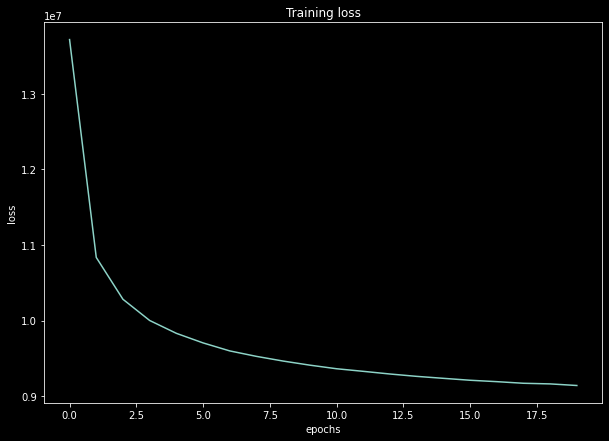

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training loss")
plt.show()

---
<font color=green>Q28:</font>
<br><font color='green'>
Which embedding matrix can you build once the training process is finished ?
</font>

---

---
We can use $W_1 \in \mathbb{R}^{V \times D}$ or $W_2^T \in \mathbb{R}^{V \times D}$ or $\frac{1}{2} (W_1 + W_2^T) \in \mathbb{R}^{V \times D}$   

---

---
<font color=green>Q29:</font>
<br><font color='green'>
Using an unsupervised learning algorithm of your choice, reduce the dimensionality of your embedding vectors into 2 dimensions and show a scatter plot of the reduced embedding vectors.
</font>

---

In [ ]:
# PCA pour visualisation avec 2 dimension
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
W_1_reduced = pca.fit_transform(W_1)
print(pca.explained_variance_ratio_.cumsum())

[0.03743779 0.07260282]


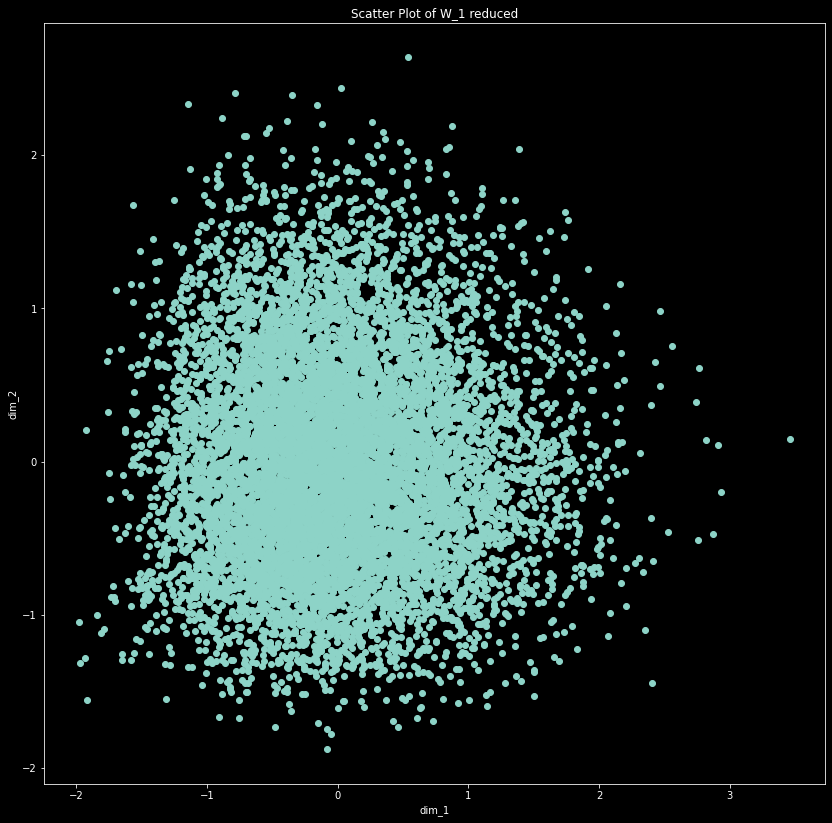

In [ ]:
# Scatter plot
fig = plt.figure(figsize=(14, 14)) 
plt.scatter(W_1_reduced[:, 0], W_1_reduced[:, 1])
plt.xlabel("dim_1")
plt.ylabel("dim_2")
plt.title("Scatter Plot of W_1 reduced")
plt.show()

In [ ]:
# List of words associated with the indices 0, ..., V-1
vector_words = [index_word[index] for index in range(len(word_index))]
# Dataframe containing the two PCA dimensions and the words
df_plot = pd.DataFrame(W_1_reduced, columns=["dim_1", "dim_2"])
df_plot["word"] = vector_words

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


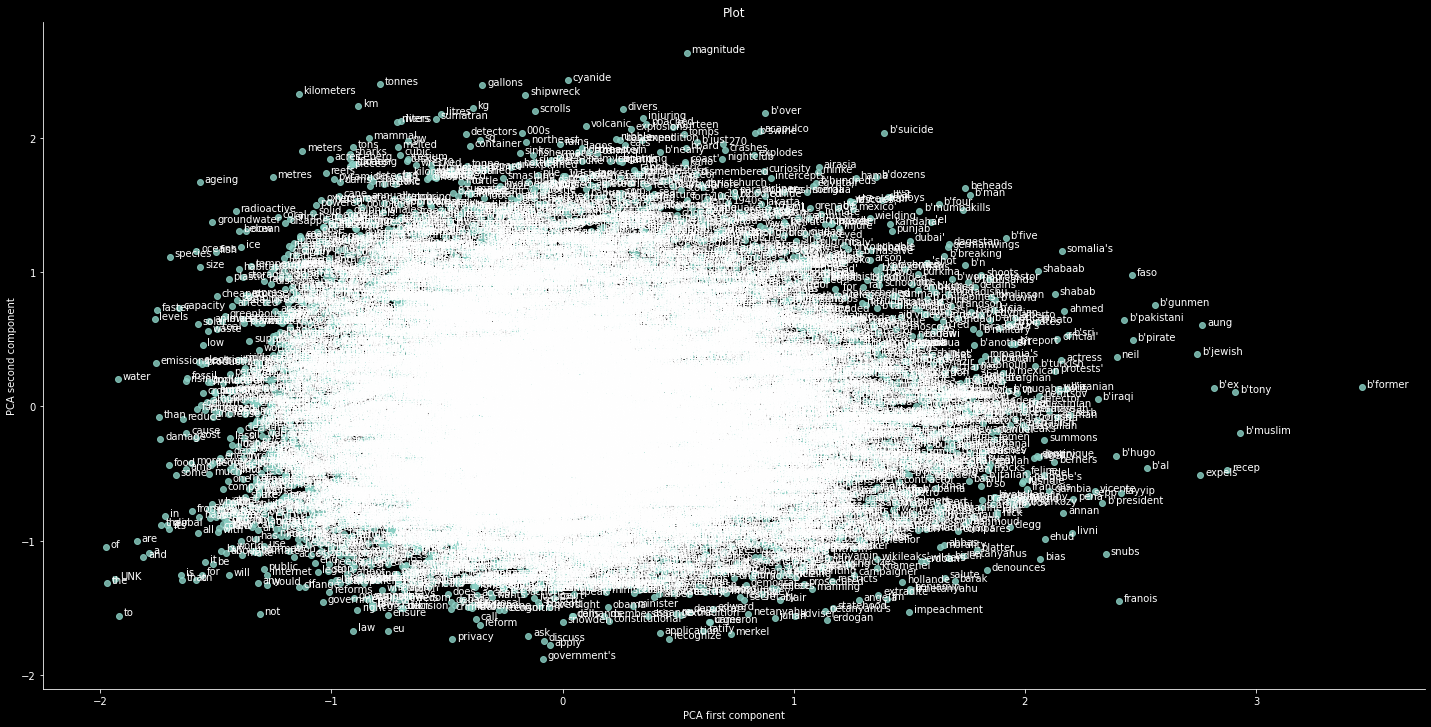

In [ ]:
# Show 100 first words
import seaborn as sns
ax = sns.lmplot('dim_1', # Horizontal axis
           'dim_2', # Vertical axis
           data=df_plot, # Data source
           fit_reg=False, # Don't fix a regression line
           size = 10,
           aspect =2 ) # size and dimension

plt.title('Plot')
# Set x-axis label
plt.xlabel('PCA first component')
# Set y-axis label
plt.ylabel('PCA second component')


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df_plot.dim_1, df_plot.dim_2, df_plot.word, plt.gca()) 

---
<font color=green>Q30:</font>
<br><font color='green'>
Show an example of an analogy like $e_{\text{France}} - e_{\text{Paris}} \approx e_{\text{England}} - e_{\text{London}}$ from the corpus using your trained embedding vectors.
</font>

---

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
def analogy(pos1, neg1, pos2, word_index, index_word, W):
  V, D = W.shape

  # don't actually use pos2 in calculation, just print what's expected
  for w in (pos1, neg1, pos2):
    if w not in word_index:
      print("Sorry, %s not in word_index" % w)
      return

  p1 = W[word_index[pos1]]
  n1 = W[word_index[neg1]]
  p2 = W[word_index[pos2]]

  vec =  - p1 + n1 + p2

  distances = pairwise_distances(vec.reshape(1, D), W, metric='cosine').reshape(V)
  idx = distances.argsort()[:10]

  # pick one that's not p1, n1, or n2
  best_idx = -1
  keep_out = [word_index[w] for w in (pos1, neg1, pos2)]
  for i in idx:
    if i not in keep_out:
      best_idx = i
      break
  # print("best_idx:", best_idx)
  print(index_word[best_idx])

### Contact

If you have any questions regarding this notebook, do not hesitate to contact: h.madmoun@imperial.ac.uk

